# The PyLandstats landscape class

The [`Landscape` class](https://pylandstats.readthedocs.io/en/latest/landscape.html) of PyLandStats defines the core object upon which all the other features of the library rely on in order to compute landscape metrics over a raster landscape.

Let us start by importing the library and defining a variable with a path to a land use/land cover (LULC) raster:

In [1]:
import matplotlib.pyplot as plt
import pylandstats as pls

lulc_filepath = '../data/raw/AS18_17.tif'

We can now initialize a `Landscape` instance as in:

In [2]:
ls = pls.Landscape(lulc_filepath)

To plot the landscape, we might use the `plot_landscape` method as in:

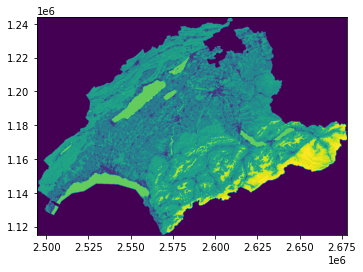

In [3]:
ls.plot_landscape()

To better understand the plot, let us add a legend to it:

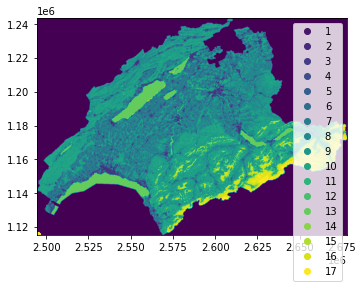

In [4]:
ls.plot_landscape(legend=True)

We probably should improve the presentation this plot, but for the purposes of this workshop, we only need to understand it. This is a LULC map where each color represents a distinct LULC class. The list of LULC classes of the map can be accessed from the `classes` attribute of the `Landscape` class:

In [5]:
ls.classes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=uint8)

Such codes correspond to the [standard nomenclature (the free tier is aggregated to 17 classes) of the Swiss land statistics datasets](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie/nomenclature-standard.html) provided by the Swiss Federal Statistical Office. For the purpose of this workshop, we are interested in the following codes:

* `10` Forest (non bushy) *Wald (ohne Gebüschwald) in German*
* `11` Bushy forest *Gebüschwald in German*
* `12` Other forest *Gehölze in German*

We can now use our `Landscape` instance to compute landscape metrics. The list of metrics implemented in PyLandStats is available [in its documentation](https://pylandstats.readthedocs.io/en/latest/landscape.html#list-of-implemented-metrics).

Let us start by computing the proportion of landscape occupied by the non-bushy forest class (`10`), and let us time it:

In [6]:
%%time
pland_forest_nobush = ls.proportion_of_landscape(class_val=10)

CPU times: user 829 ms, sys: 8.66 ms, total: 838 ms
Wall time: 845 ms


Let us now execute (and time) the same code again:

In [7]:
%%time
pland_forest_nobush = ls.proportion_of_landscape(class_val=10)

CPU times: user 4.02 ms, sys: 348 µs, total: 4.37 ms
Wall time: 3.02 ms


Note that he second execution is much faster. This is because PyLandStats stores intermediate results that are used to compute other metrics, e.g., the `_patch_class_ser` and `_patch_area_ser` attributes:

In [8]:
ls._patch_class_ser

0          1
1          1
2          1
3          1
4          1
          ..
121533    17
121534    17
121535    17
121536    17
121537    17
Name: class_val, Length: 121538, dtype: uint8

In [9]:
ls._patch_area_ser

0          10000.0
1          10000.0
2          10000.0
3          10000.0
4          10000.0
            ...   
121533    140000.0
121534     40000.0
121535    190000.0
121536     20000.0
121537    560000.0
Name: area, Length: 121538, dtype: float64

Since such attributes contain information of all the patches of the landscape (i.e., the patches of all LULC classes), computing this metrics for other classes will be faster now. 

Let us now compute the proportion of landscape of the three forest classes:

In [10]:
class_dict = {10: 'Forest (non-bushy)', 11: 'Bushy forest', 12: 'Other forest'}

In [11]:
for class_val in class_dict:
    pland = ls.proportion_of_landscape(class_val)
    print(f'PLAND of {class_dict[class_val]} ({class_val}) is: {pland:.4f}')

PLAND of Forest (non-bushy) (10) is: 28.6121
PLAND of Bushy forest (11) is: 0.6780
PLAND of Other forest (12) is: 2.3848


Such attributes are cached as we execute metrics that require them. For instance, if we now compute (and time the execution) of the area-weighted fractal dimension:

In [12]:
%%time
ls.fractal_dimension_am(class_val=10)

CPU times: user 12.1 s, sys: 226 ms, total: 12.3 s
Wall time: 12.1 s


1.2654441461761565

The list of patch perimeters will be cached as the `_patch_perimeter_ser` attribute:

In [13]:
ls._patch_perimeter_ser

0          400.0
1          400.0
2          400.0
3          400.0
4          400.0
           ...  
121533    1800.0
121534    1200.0
121535    3000.0
121536     600.0
121537    6000.0
Name: perimeter, Length: 121538, dtype: float64

And if we now compute the same metric again, the execution will be much faster:

In [14]:
%%time
ls.fractal_dimension_am(class_val=10)

CPU times: user 7.05 ms, sys: 0 ns, total: 7.05 ms
Wall time: 6.37 ms


1.2654441461761565

Finally, instead of computing metrics individually, we can compute multiple metrics for multiple classes as a pandas data-frame of metrics with the `compute_class_metrics_df` method:

In [15]:
metrics = ['proportion_of_landscape', 'number_of_patches', 'edge_density', 'fractal_dimension_am']
classes = list(class_dict.keys())

In [16]:
%%time
class_metrics_df = ls.compute_class_metrics_df(metrics=metrics, classes=classes)

CPU times: user 640 ms, sys: 849 µs, total: 641 ms
Wall time: 621 ms


The returned object is a pandas `DataFrame` upon which we can operate as we would with any other pandas `DataFrame`:

In [17]:
class_metrics_df

,proportion_of_landscape,number_of_patches,edge_density,fractal_dimension_am
class_val,,,,
10,28.612102,9486,28.708524,1.265444
11,0.677965,2053,1.677853,1.096710
12,2.384779,20106,8.714368,1.025412
